In [1]:
%run setup.py

In [2]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx = (stars['ifmodelling']==1) & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) & np.isfinite(stars['[M/H]'])

stars = stars.loc[idx,:].reset_index(drop=True)

# modes = pd.read_excel(rootpath+'surface/sample/modes.xlsx')

# plot model data

In [3]:
data = pd.read_parquet('../data/fDnu_on_tracks_data.parquet')

In [4]:
data = data.dropna(subset=['fDnu']).reset_index(drop=True)

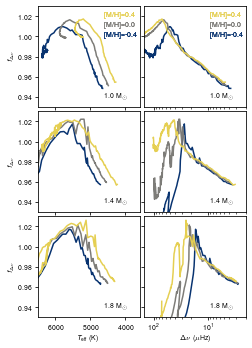

In [5]:
import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=-0.5,vmax=0.5)


fig, axes = plt.subplots(figsize=mnras_size(ratio=1.4,column='one'), nrows=3, ncols=2, 
                         squeeze=False, constrained_layout=True)
# axes = axes.reshape(-1)


styles = {'marker':'.', 's':4, 'norm':norm, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}

fehs = [-0.4, 0., 0.4]
masses = [1.0, 1.4, 1.8]
for irow in range(3):
    for ifeh in range(3):
        t = data[(data['mass']==masses[irow]) & (data['feh']==fehs[ifeh])]
        idx = t.index>0
        axes[irow,0].plot(t['Teff'][idx][5:-10], t['fDnu'][idx][5:-10], color=plt.cm.cividis(norm(t['feh'].iloc[0])))
        axes[irow,1].plot(t['Dnu_freq'][idx][5:-10], t['fDnu'][idx][5:-10], color=plt.cm.cividis(norm(t['feh'].iloc[0])))
        
    axes[irow,0].set_xlim(6500, 3600)
    axes[irow,1].set_xlim(150., 2.)
    axes[irow,1].set_xscale('log')
    
    if irow<2:
        axes[irow,0].set_xticklabels([])
        axes[irow,1].set_xticklabels([])

    axes[irow,1].set_yticklabels([])
    axes[irow,0].set_ylabel('$f_{\\Delta\\nu}$')
    
    axes[irow,0].set_ylim(0.93, 1.03)
    axes[irow,1].set_ylim(0.93, 1.03)
    
    for icol in range(2):
        axes[0,icol].text(0.65, 0.9, '[M/H]=0.4', color=plt.cm.cividis(norm(0.4)), transform=axes[0,icol].transAxes, ha='left' )
        axes[0,icol].text(0.65, 0.8, '[M/H]=0.0', color=plt.cm.cividis(norm(0.)), transform=axes[0,icol].transAxes, ha='left' )
        axes[0,icol].text(0.65, 0.7, '[M/H]=-0.4', color=plt.cm.cividis(norm(-0.4)), transform=axes[0,icol].transAxes, ha='left' )
        axes[irow,icol].text(0.65, 0.1,'{:0.1f} M$_\\odot$'.format(masses[irow]), transform=axes[irow,icol].transAxes, ha='left')

axes[-1,0].set_xlabel('$T_{\\rm eff}$ (K)')
axes[-1,1].set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)')

fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)


filename = 'Fig.7_fDnu.pdf'

# plt.savefig(filename)
# os.system(to_overleaf(filename, 'figures'))

# predict fdnu with stellar parameters
## a fitting relation

In [9]:
suf = '_micp'
original_cols = ['Dnu_freq_o', 'Dnu_freq', 'star_mass', 'radius', 'surf_corr_at_numax', 'density']
to_append_cols = [s+suf for s in ['Dnu_freq_o', 'Dnu_freq', 'mass', 'radius', 'surf_corr', 'density']]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)
    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)


  0%|          | 0/1276 [00:00<?, ?it/s]

In [44]:
for suffix in ['_micp']: #, '_combined_linear']: #
    gval = 'g'+suffix
    dval = 'density'+suffix
    mval = 'mass'+suffix
    rval = 'radius'+suffix
    e_gval = 'e_g'+suffix
    e_dval = 'e_density'+suffix
    e_mval = 'e_mass'+suffix
    e_rval = 'e_radius'+suffix
    stars[gval] = stars[mval]/stars[rval]**2.
    stars[e_gval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (2*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[gval]
    stars[dval] = stars[mval]/stars[rval]**3.
    stars[e_dval] = ((stars[e_mval]/stars[mval])**2.0 \
                      + (3*stars[e_rval]/stars[rval])**2.0)**0.5 * stars[dval]

In [45]:
stars.head()

,index,KIC,ifsplitting,ifmodelling,ifsupressed,comments,stage,names,_RA,_DE,...,e_Dnu_freq_micp,e_mass_micp,e_radius_micp,e_surf_corr_micp,density_micp,e_density_micp,f,e_f,g_micp,e_g_micp
0,0,1,NaN,1,0.0,NaN,esg,mu Her,266.61469,27.720621,...,0.156332,0.018750,0.009622,0.187400,0.220312,0.005242,1.133594,0.013693,0.378142,0.007647
1,1,2991448,-1.0,1,0.0,NaN,esg,NaN,291.82490,38.113190,...,0.080585,0.004345,0.001764,0.017046,0.202851,0.001090,1.008331,0.002980,0.344454,0.001668
2,3,4346201,-1.0,1,0.0,NaN,esg,NaN,285.28595,39.498050,...,0.322240,0.023635,0.017292,0.084080,0.168407,0.005714,1.182267,0.019849,0.321010,0.008731
3,5,5607242,1.0,1,0.0,NaN,esg,NaN,287.64633,40.843060,...,0.100740,0.038915,0.025807,0.029173,0.088682,0.003996,1.243708,0.028321,0.213299,0.008136
4,6,5689820,1.0,1,0.0,NaN,esg,NaN,286.22723,40.927730,...,0.075431,0.026365,0.016155,0.053696,0.093835,0.002815,1.205252,0.018082,0.220166,0.005668


In [46]:
Dnu_sun_model = 135.0959
density_sun_model = 1.00570
stars['f'] = (stars['Dnu_freq_micp']/Dnu_sun_model)*(stars['density_micp']/density_sun_model)**-0.5
stars['e_f'] = stars['f'] * ((stars['e_Dnu_freq_micp']/stars['Dnu_freq_micp'])**2.0 + \
                                0.5*(stars['e_density_micp']/stars['density_micp'])**2.0 )**0.5

In [48]:
# plt.hist(stars['f'])
idx = stars['KIC']==0
stars.loc[idx,'f']

50    0.997927
Name: f, dtype: float64

0.8343466873604409
0.8885915208305417
betas: np.array([4.0264, 0.1688, -0.1863, -10.2631, 11.4648, -4.2125, 0.0015])
Sun: 1.016


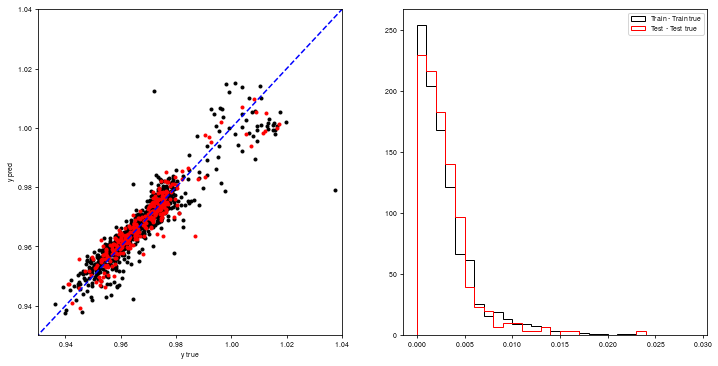

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# sample = stars.dropna(subset=['mass_micp', 'radius_micp', 'Teff', '[M/H]', 'fsc'] ).reset_index(drop=True)
# X = sample[['mass_micp', 'radius_micp', 'Teff', '[M/H]']].to_numpy()

sample = stars.dropna(subset=['numax', 'Dnu', 'Teff', '[M/H]', 'f'] ).reset_index(drop=True)
sample = sample[sample['[M/H]']>-0.8].reset_index(drop=True)
cols = ['numax', 'Dnu', 'Teff',  '[M/H]']
sample['numax'] = sample['numax']/3090
sample['Dnu'] = sample['Dnu']/135.1
sample['Teff'] = sample['Teff']/5777.
for col in cols:
    sample[col+'^1'] = sample[col]**1.
    sample[col+'^2'] = sample[col]**2.
    sample[col+'^3'] = sample[col]**3.
    sample[col+'^4'] = sample[col]**4.
X = sample[['numax', 'Dnu', 'Teff', 'Teff^2', 'Teff^3', '[M/H]']].to_numpy()
X[:,0:2] = np.log10(X[:,0:2])
# X[:,0:3] = np.log10(X[:,0:3])
# X[:,0:4] = np.log10(X[:,0:4])
y = sample['f'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

regr = LinearRegression().fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

betas = np.concatenate([[regr.intercept_],regr.coef_])
print('betas: np.array([{:s}])'.format(', '.join(['{:0.4f}'.format(f) for f in betas ] )))
print('Sun: {:0.3f}'.format(betas[0] + betas[3] + betas[4] + betas[5]))

fig, axes = plt.subplots(figsize=[12,6], nrows=1, ncols=2, squeeze=False)
axes = axes.reshape(-1)
# plt.plot(stars['fdnu'], stars['Dnu_freq_o_micp']/135.1*stars['density_micp']**-0.5, 'k.')
axes[0].plot(y_train, y_train_pred, 'k.')
axes[0].plot(y_test, y_test_pred, 'r.')
axes[0].axis([0.93,1.04,0.93,1.04])
axes[0].plot([0.1,10.],[0.1,10.], 'b--')
axes[0].set_xlabel('y true')
axes[0].set_ylabel('y pred')

bins = np.arange(0., 0.03, 0.001)
axes[1].hist(np.abs(y_train-y_train_pred), bins=bins, color='k', histtype='step', label='Train - Train true', density=True)
axes[1].hist(np.abs(y_test-y_test_pred), bins=bins, color='r', histtype='step', label='Test - Test true', density=True)
axes[1].legend(fontsize=fontsize)
# axes[1].hist(sample['e_f'], bins=bins, color='b', histtype='step')

In [ ]:
print(betas[0]

## a software tool

See scaling.py